In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 線形連立方程式

In [4]:
A, b = np.random.rand(3000, 3000), np.random.rand(3000, 100)

In [5]:
%%timeit
x = np.dot(np.linalg.inv(A),b)

600 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
x = np.linalg.solve(A, b)

201 ms ± 6.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 量子ハイゼンベルグ模型の対角化I

In [7]:
A = np.array([[1,0,0,0], [0,-1,2,0], [0,2,-1,0], [0,0,0,1]])/4
eig, vec = np.linalg.eigh(A)

# 量子ハイゼンベルグ模型の対角化II

In [8]:
def HMatrix(ns, bl):
    dim = 2**ns
    H = np.zeros([dim, dim])
    ind = np.arange(dim) # スピン状態を表す配列
    for bond in bl:      # それぞれのbondに対して計算する
        bs = ind & bond
        ind1 = (bs != 0) & (bs != bond)
        # 各状態に対しボンド上の2スピンが異符号ならTrueとなる配列
        H[ind,ind] += 1 - 2*ind1  # 対角要素に +1 or -1
        ind2 = ind[ind1]
        # ボンド上の2スピンが異符号の状態を抜き出した配列
        H[ind2^bond, ind2] += 2  # 非対角要素
    return H/4

In [9]:
H = HMatrix(3, [0b011, 0b110, 0b101]) # リストは[3,6,5]でも同じ
eig, vec = np.linalg.eigh(H)
print(eig)

[-0.75 -0.75 -0.75 -0.75  0.75  0.75  0.75  0.75]


In [10]:
N = 5
bl = [3<<i for i in range(N-1)] + [2**(N-1)+1]
  # << はビットシフト演算子. 周期的にならないので, 補正を加えている

# 量子ハイゼンベルグ模型の対角化III

In [11]:
from scipy.sparse import csr_matrix, linalg
H_csr = csr_matrix(H)
eig, vec = linalg.eigsh(H_csr, 3, which='SA')
  # whichは計算する固有値の指定. SAは値が小さいものから計算
  # LAは値の大きいもの, SM,LMはそれぞれ絶対値の小さい,大きいもの
  # から順に計算してk(=3)個出力する 

In [12]:
def multiplyH(v, bl):
    bl = np.array(bl)
    vind = np.nonzero(v != 0)[0] # vの非零要素のindexを所得
    vn = np.zeros_like(v)        # vと同じ形状で値が0の行列
    for bond in bl:
        bs = vind & bond
        ind1 = (bs != 0) & (bs != bond)
        vn[vind] += v[vind] * (1-2*ind1)   # 対角項
        ind2 = vind[ind1]
        vn[ind2 ^ bond] += v[ind2] * 2     # 非対角項
    return vn/4

In [13]:
N = 20
H = lambda v : multiplyH(v, bl)
op = linalg.LinearOperator(shape=(2**N, 2**N), matvec=H)
 # shapeで行列の次元を指定. matvacは行列ベクトル積Axの作用を指定
 # 問題によってはA^Hxや行列行列積ARなどが必要となり, それぞれ
 # rmatvecとmatmatで指定する
eig, vec = linalg.eigsh(op, k=3, which='SA')

# 発展問題(線形連立方程式)

In [14]:
def user_lu(A):
    L, U = np.eye(len(A)), np.zeros_like(A)
    for j in range(len(A)):
        for i in range(j+1):
            U[i,j] = A[i,j]-L[i,:j]@U[:j,j]
        L[j+1:,j] = (A[j+1:,j]-L[j+1:,:j]@U[:j,j])/U[j,j]
    return L, U

In [15]:
A = np.random.rand(300,300)
L, U = user_lu(A)
print(np.linalg.norm(A-L@U))

3.4547528578226966e-11


In [16]:
import scipy.linalg
P, L, U = scipy.linalg.lu(A)
print(np.linalg.norm(A-P@L@U))

1.2717834482220401e-13


In [17]:
# テキストには含まれない
from time import time
time_s = time()
L, U = user_lu(A)
print(time()-time_s)
time_s = time()
P, L, U = scipy.linalg.lu(A)
print(time()-time_s)

0.11499691009521484
0.0022089481353759766


# 発展問題(量子ハイゼンベルグ模型の対角化III)

In [18]:
from scipy.sparse import csr_matrix, coo_matrix, linalg
def HMatrix_data(ns, bl, ind):
    data = np.empty(0)
    row, col = np.empty(0,dtype=int), np.empty(0,dtype=int)
    for bond in bl:
        bs = ind & bond
        ind1 = (bs != 0) & (bs != bond)
        ind2 = ind[ind1]
        unit = np.ones(len(ind2))
        data = np.append(data, np.append(1-2*ind1, 2*unit))
        row = np.append(row, np.append(ind, ind2^bond))
        col = np.append(col, np.append(ind, ind2))
    return data/4, row, col

In [19]:
N = 15
bl = [3<<i for i in range(N-1)] + [2**(N-1)+1]
nsz = [bin(i).count("1") for i in np.arange(2**N)]
map_ind = np.zeros(2**N, dtype=int)
for n in np.arange(N+1):
    if n != N//2: continue
    ind = np.where(nsz==n)[0]
    map_ind[ind] = np.arange(len(ind))
    data, row, col = HMatrix_data(N, bl, ind)
    row, col = map_ind[row], map_ind[col]
    A_coo=coo_matrix((data,(row,col)), (len(ind),len(ind)))
    A_csr=csr_matrix(A_coo)
    if n==0 or n==N: eig = [A_csr[0,0]]
    else: eig, vec = linalg.eigsh(A_csr, k=2, which='SA')
    print(n, eig)

7 [-6.53366757 -6.53366757]


In [20]:
# プロットと図の保存用(テキスト中には含まれない)
x, ans = [], []
for N in np.arange(1, 23):
    bl = [3<<i for i in range(N-1)] + [2**(N-1)+1]
    nsz = [bin(i).count("1") for i in np.arange(2**N)]
    map = np.zeros(2**N, dtype=int)
    for n in np.arange(N+1):
        if n!=N//2: continue
        ind = np.where(nsz==n)[0]
        map[ind] = np.arange(len(ind))

        data, row, col = HMatrix_data(N, bl, ind)
        row, col = map[row], map[col]
        A_coo = coo_matrix((data, (row, col)), shape=(len(ind), len(ind)))
        A_csr = csr_matrix(A_coo)
        if n==0 or n==N: eig = [A_csr[0,0]]
        else             : eig, vec = linalg.eigsh(A_csr, k=1, which='SA')
        x.append(N)
        ans.append(eig[0]/N)

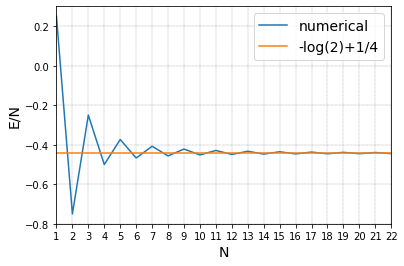

In [21]:
plt.plot(x, np.array(ans), label='numerical')
plt.plot(x, -np.log(2)*np.ones(len(x))+0.25, label='-log(2)+1/4')
plt.xlabel("N", fontsize=14)
plt.xticks(range(23))
plt.xlim(1, 22)
plt.ylabel("E/N", fontsize=14)
plt.legend(fontsize=14)
plt.grid(color='black', linestyle='dotted', linewidth=0.3)
plt.show()